This is me trying to figure out stuff. My current goals are to:

1. Download a HuggingFace model
2. Visualize the model somehow
3. Re-evaluate what to do from there

In [71]:
from transformers import AutoImageProcessor, ResNetForImageClassification
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [74]:
processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50").to(device = device)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [3]:
type(model)

transformers.models.resnet.modeling_resnet.ResNetForImageClassification

In [4]:
from datasets import load_dataset

dataset = load_dataset("huggingface/cats-image")
image = dataset["test"]["image"][0]

In [75]:
inputs = processor(image, return_tensors="pt").to(device = device)

In [6]:
from torchview import draw_graph

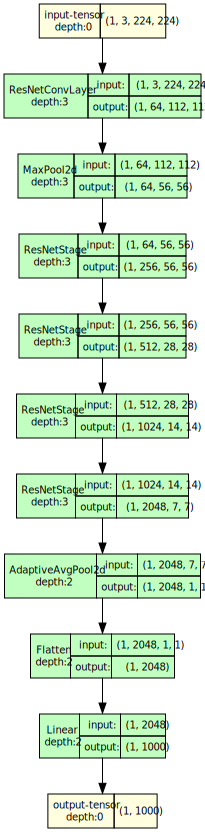

In [8]:
model_graph = draw_graph(model, input_data = inputs, device='meta')
model_graph.visual_graph

In [26]:
layer_list = []
for name, layer in model.named_modules():
    layer_list.append(layer)

In [29]:
len(layer_list)

286

In [ ]:
dir(model)

In [22]:
modulelist = [module for module in model.modules() if not isinstance(module, type(model))]

In [35]:
modulelist[5]

ReLU()

In [76]:
from torchvision.models import resnet50
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision.models.detection.mask_rcnn import MaskRCNN
from torchvision.models.detection.backbone_utils import LastLevelMaxPool
from torchvision.ops.feature_pyramid_network import FeaturePyramidNetwork


# To assist you in designing the feature extractor you may want to print out
# the available nodes for resnet50.
m = resnet50()
train_nodes, eval_nodes = get_graph_node_names(resnet50())

In [38]:
childlist = [child for child in model.children()]

In [43]:
childlist[0]

ResNetModel(
  (embedder): ResNetEmbeddings(
    (embedder): ResNetConvLayer(
      (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
    )
    (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (encoder): ResNetEncoder(
    (stages): ModuleList(
      (0): ResNetStage(
        (layers): Sequential(
          (0): ResNetBottleNeckLayer(
            (shortcut): ResNetShortCut(
              (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (normalization): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
            (layer): Sequential(
              (0): ResNetConvLayer(
                (convolution): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (normalizatio

In [44]:
def get_children(model: torch.nn.Module):
    # get children form model!
    children = list(model.children())
    flatt_children = []
    if children == []:
        # if model has no children; model is last child! :O
        return model
    else:
       # look for children from children... to the last child!
       for child in children:
            try:
                flatt_children.extend(get_children(child))
            except TypeError:
                flatt_children.append(get_children(child))
    return flatt_children

In [46]:
childlist = get_children(model)

In [51]:
childlist[2]

ReLU()

In [48]:
childlist[0].weight







Parameter containing:
tensor(..., device='meta', size=(64, 3, 7, 7), requires_grad=True)

In [97]:
model.modules()

<generator object Module.modules at 0x00000240318084A0>

In [57]:
list(model.children())[1]

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=2048, out_features=1000, bias=True)
)

In [66]:
def predict(self, test_images):
    self.eval()
    # model is self(VGG class's object)
    
    count = test_images.shape[0]
    result_np = []
        
    for idx in range(0, count):
        # print(idx)
        img = test_images[idx, :, :, :]
        img = np.expand_dims(img, axis=0)
        img = torch.Tensor(img).permute(0, 3, 1, 2).to(device)
        # print(img.shape)
        pred = self(img)
        pred_np = pred.cpu().detach().numpy()
        for elem in pred_np:
            result_np.append(elem)
    return result_np

In [68]:
model(inputs)

AttributeError: 

In [76]:
with torch.no_grad():
    logits = model(**inputs).logits

In [130]:
logits[0].argmax(-1).item()

282

In [79]:
predicted_label = logits.argmax(-1).item()
print(model.config.id2label[predicted_label])

tiger cat


In [83]:
import matplotlib.pyplot as plt

In [95]:
img_tensor = inputs['pixel_values'][0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


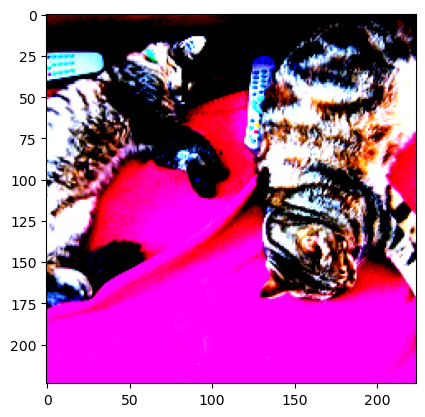

In [96]:
plt.imshow(img_tensor.permute(1, 2, 0))

In [97]:
img_tensor.shape

torch.Size([3, 224, 224])

In [98]:
import torch.nn as nn

In [122]:
garbage_tens = nn.Conv2d(1,3,224,bias = False).weight.permute(1,0,2,3)[0].to(device = device).detach()

In [124]:
garbage_tens

tensor([[[-1.1954e-03,  2.6606e-03, -2.2359e-03,  ..., -3.1823e-04,
          -2.3954e-04, -3.1716e-03],
         [ 5.7091e-04, -1.7013e-03, -2.1935e-03,  ..., -2.4019e-03,
           1.5706e-03,  4.1076e-03],
         [ 1.6346e-03,  3.2764e-03, -1.9379e-03,  ...,  1.6039e-03,
           3.6406e-03, -2.6259e-03],
         ...,
         [ 3.4888e-03, -2.3082e-03,  3.9280e-03,  ...,  1.1325e-03,
           3.8047e-03,  3.7540e-03],
         [ 2.7239e-03, -3.2820e-03,  3.4379e-03,  ..., -2.7503e-03,
          -2.2770e-03, -1.7767e-03],
         [ 2.9823e-03,  2.3624e-03,  2.9492e-03,  ...,  2.7520e-03,
          -2.6413e-03,  1.0326e-03]],

        [[-2.7560e-03, -6.6998e-04,  3.2805e-03,  ...,  8.8518e-04,
           1.5233e-03,  2.2329e-03],
         [ 1.3983e-03,  3.7896e-04,  5.2822e-05,  ...,  1.8660e-03,
           1.8677e-03, -1.0117e-03],
         [-7.8169e-04, -6.2541e-05, -9.8092e-06,  ..., -3.6437e-03,
          -1.8320e-03, -4.4352e-03],
         ...,
         [ 1.7643e-03, -3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


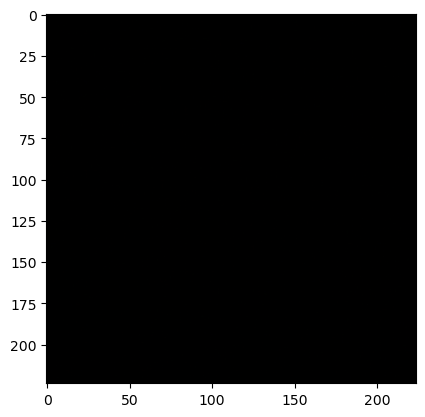

In [123]:
plt.imshow(garbage_tens.permute(1, 2, 0))